In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py


In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [3]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

# Problem 1
1)

Histogram of 4 features


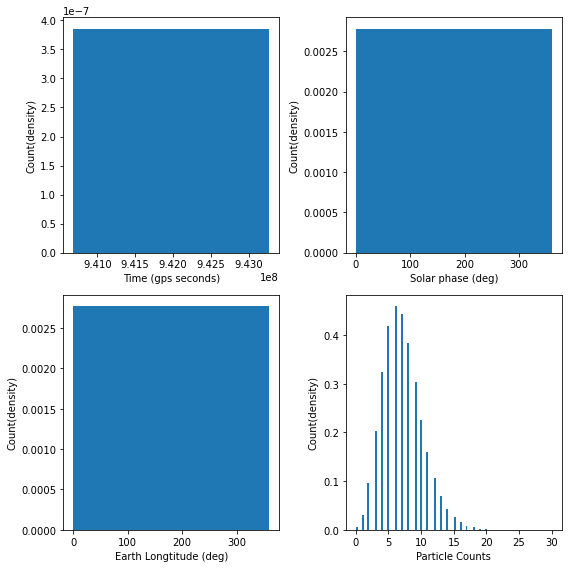

In [19]:
plt.rcParams["figure.figsize"] = (8,8)
print("Histogram of 4 features")
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2,i%2].hist(data[i,:],100,density=True)
    ax[i//2,i%2].set_ylabel("Count(density)")
ax[0,0].set_xlabel("Time (gps seconds)")
ax[0,1].set_xlabel("Solar phase (deg)")
ax[1,0].set_xlabel("Earth Longtitude (deg)")
ax[1,1].set_xlabel("Particle Counts")

plt.tight_layout()
plt.show()

From the histograms, we can see that the first three features - time, solar phase, earth longitude, are uniformly distributed, and particle counts is Poisson-like distributed. To verify whether the particle counts is Poisson distributed, we compare it with Poisson(mu=6).

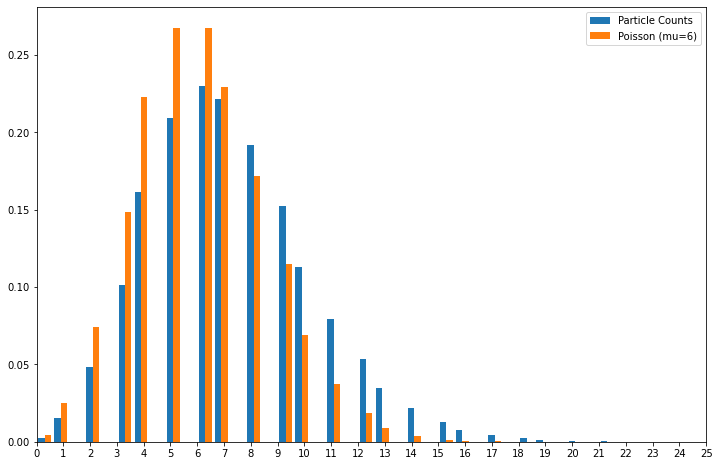

In [46]:
fig, ax = plt.subplots(1,1)
p_dis = stats.poisson.rvs(mu=6, loc=0, size=data.shape[1], random_state=None)
ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
ax.set_xlim([0,25])
ax.set_xticks(np.arange(0,26,1))
ax.legend(['Particle Counts','Poisson (mu=6)'])
plt.show()

Comparing to the Poisson, the distribution of Pariticle Counts has some difference, so there must be contamination.

Histogram of the first 3 features, weighted by Particle counts


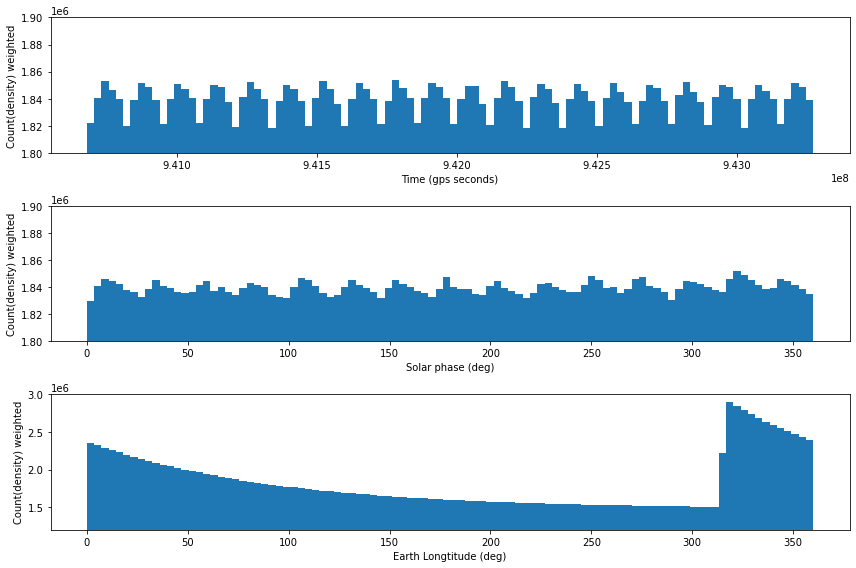

In [21]:
print("Histogram of the first 3 features, weighted by Particle counts")
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots(3, 1)
for i in range(3):
    ax[i].hist(data[i,:],100,weights=data[3,:])
    ax[i].set_ylabel("Count(density) weighted")
ax[0].set_xlabel("Time (gps seconds)")
ax[0].set_ylim([1.8e6,1.9e6])
ax[1].set_xlabel("Solar phase (deg)")
ax[1].set_ylim([1.8e6,1.9e6])
ax[2].set_xlabel("Earth Longtitude (deg)")
ax[2].set_ylim([1.2e6,3e6])

plt.tight_layout()
plt.show()

The plots above show how particle counts varies by the first 3 features. All of them are showing periodic changes. The period of Time and Solar Phase are the same, but Earth Longitude has aparently greater period. I speculate that the data contamination described above originated from this.

In [70]:
def _split (data,minmax):
    if (minmax[0]<minmax[1]):
        return data[:,(data[2]>=minmax[0])&(data[2]<minmax[1])]
    return np.concatenate([data[:,(data[2]>=minmax[0])],data[:,(data[2]<minmax[1])]],axis=1)
def comp_p (data,minmax):
    data = _split(data,minmax)
    d_mean = np.mean(data[3,:])
    fig, ax = plt.subplots(1,1)
    p_dis = stats.poisson.rvs(mu=d_mean, loc=0, size=data.shape[1], random_state=None)
    ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
    ax.set_xlim([0,25])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,26,1))
    ax.set_title(str(minmax)+", mean=%.3f"%d_mean)
    ax.legend(['Particle Counts','Poisson (mu=%.3f)'%d_mean])
    return ax, d_mean

D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


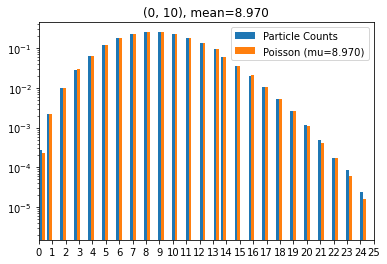

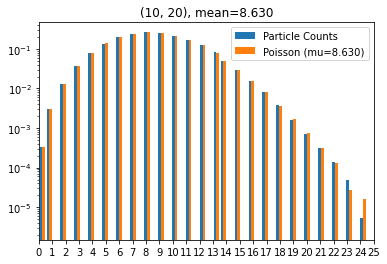

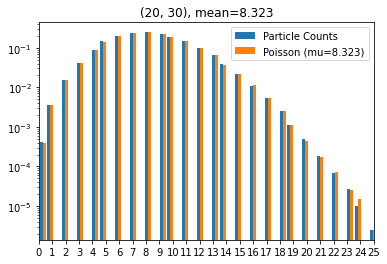

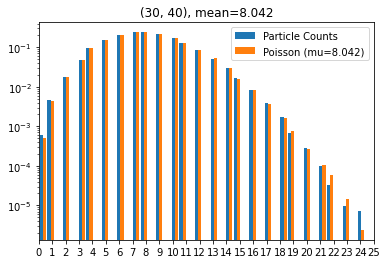

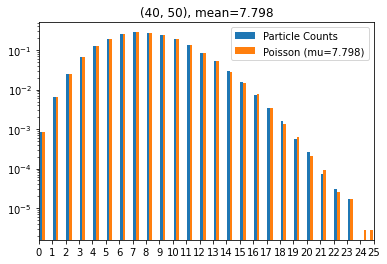

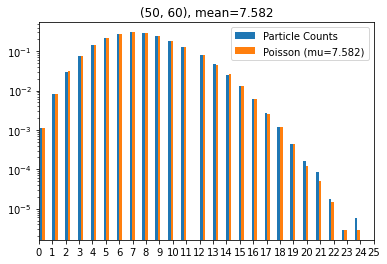

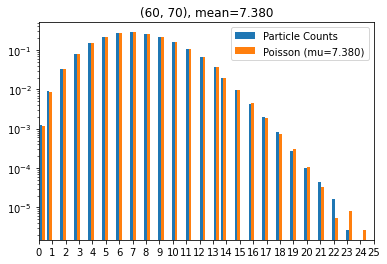

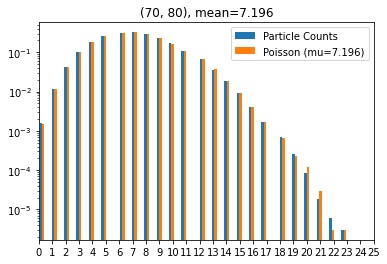

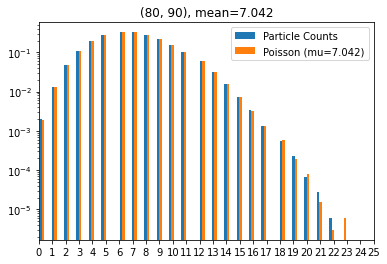

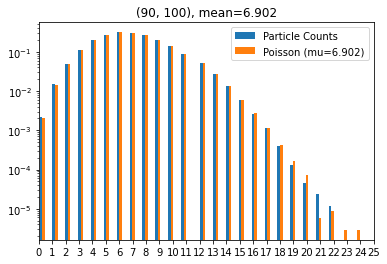

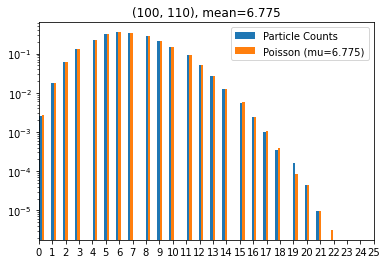

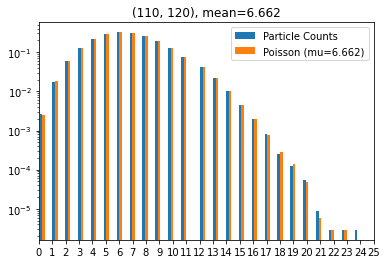

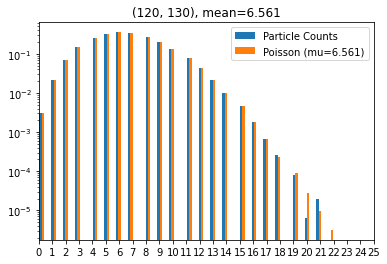

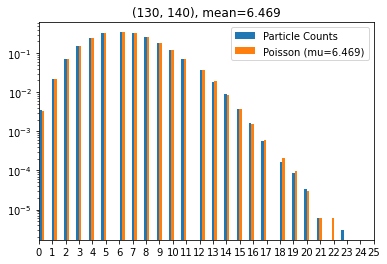

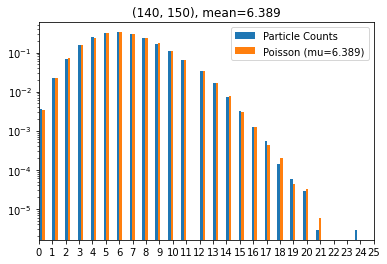

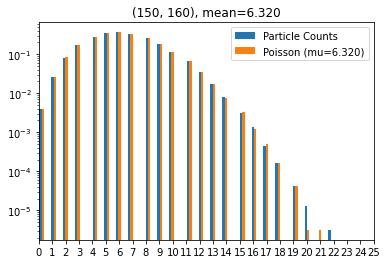

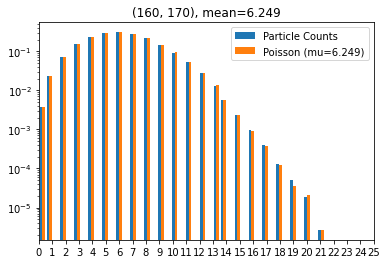

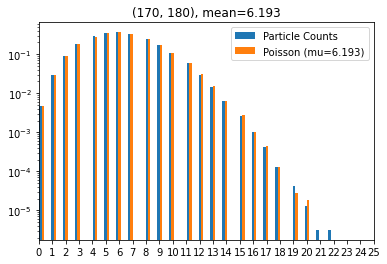

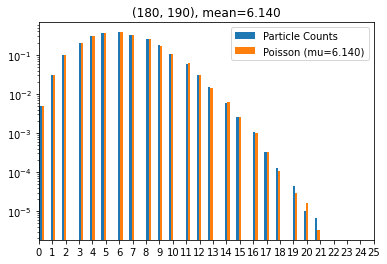

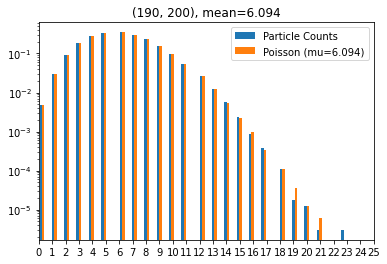

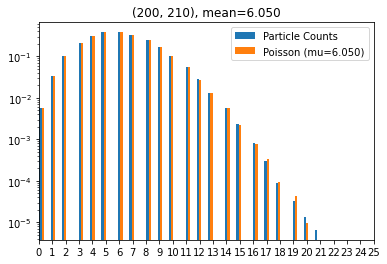

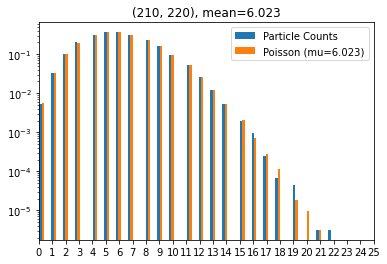

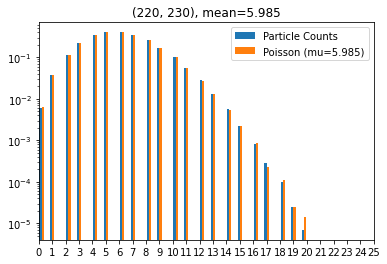

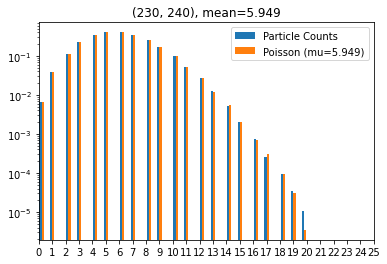

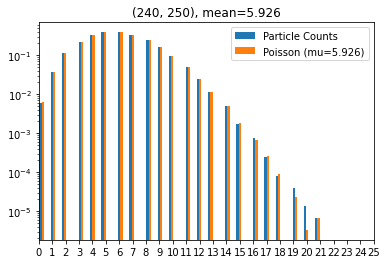

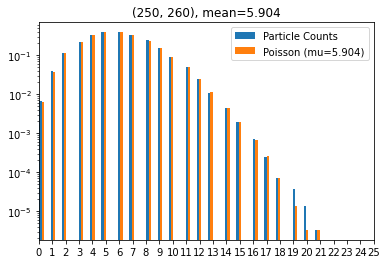

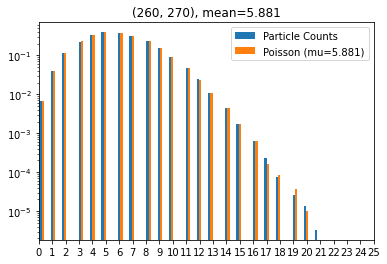

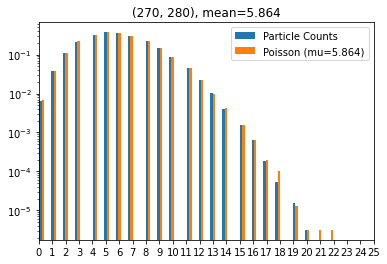

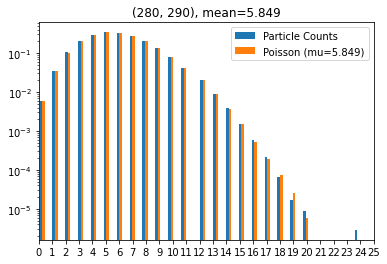

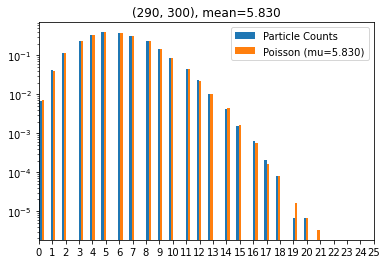

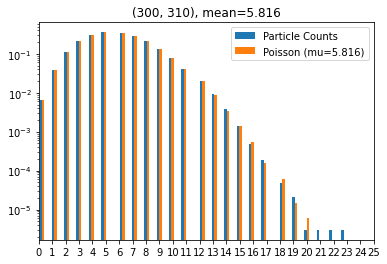

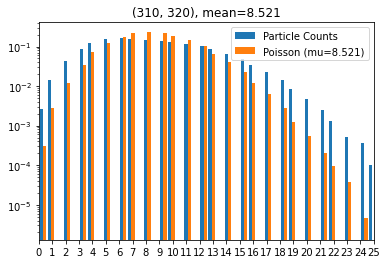

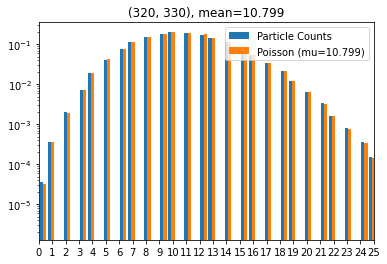

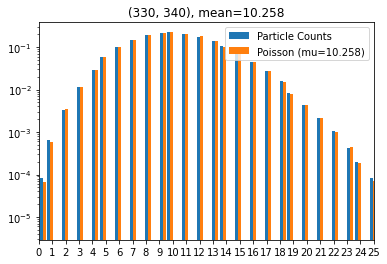

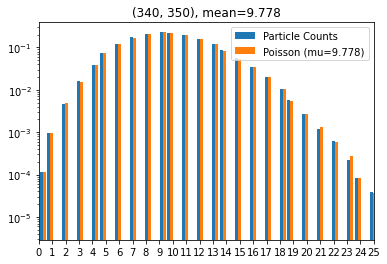

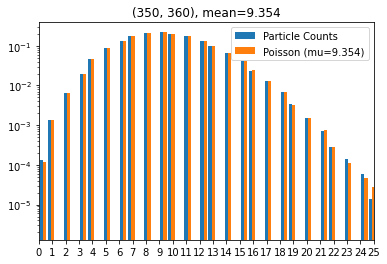

In [71]:
scan = np.arange(0,370,10)
minmax_range = [(scan[i],scan[i+1]) for i in range(scan.shape[0]-1)]
mean_list=[]
for minmax in minmax_range:
    _,mean = comp_p(data,minmax)
    mean_list.append(mean)

I split the longitude into 36 segments with 10 as the step and find that each segment follows Poisson distribution but with different mean value. Not let's find the pattern of the mean value.

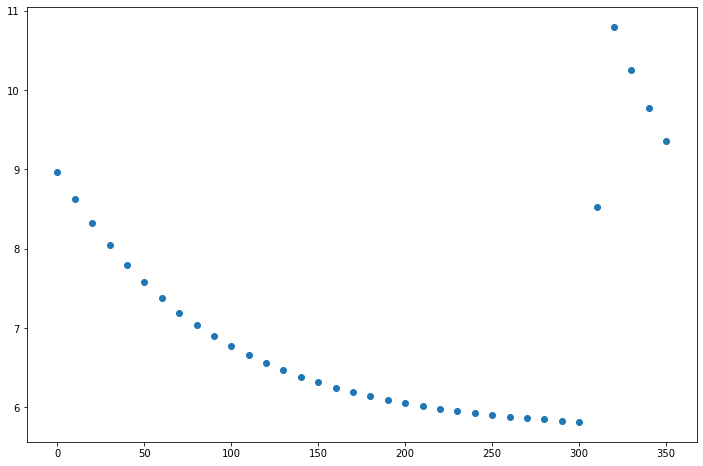

In [105]:
fig,ax=plt.subplots(1,1)
ax.scatter(scan[:-1],mean_list)

It seems that the breakpoint is at 310, let's rearrange the x-axis so that 310-360 is connected with 0-300

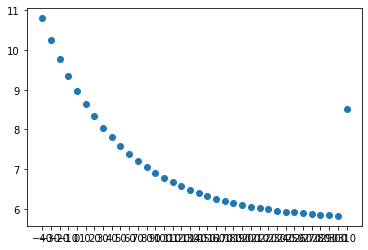

In [77]:
fig,ax=plt.subplots(1,1)
x=np.arange(-40,320,10)
y=np.roll(mean_list,4)
ax.scatter(x,y)
ax.set_xticks(np.arange(-40,320,10))
plt.show()

It seems the pattern follows polynomial functions. Let's try.

            3             2
-2.155e-07 x + 0.0001459 x - 0.03532 x + 9.026


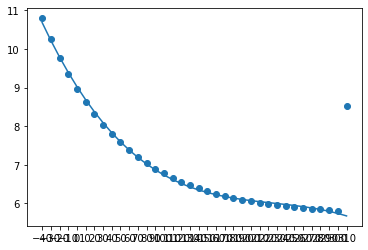

In [78]:
parameter = np.polyfit(x[:-1], y[:-1], 3)
p = np.poly1d(parameter,variable='x')
print(p)

fig,ax=plt.subplots(1,1)
ax.scatter(x,y)
ax.plot(x,p(x))
ax.set_xticks(np.arange(-40,320,10))
plt.show()

2) In conclusion, the background is a mixture of Poisson distribution with different mean value. The mean value follows cubed function: -2.155e-07 x^3 + 0.0001459 x^2 - 0.03532 x + 9.026 except the aberrant point at longitude=310. The variable x represent Earth Longitude.
3) To find out the relationship between Particle counts and time, let's take first 100k data and make a hist2D plot. If we use the whole dataset, the pattern vanishes.

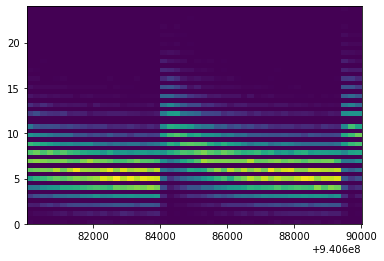

In [66]:
plt.hist2d(data[0,:100000],data[3,:100000],50)
plt.show()

3) From y-axis, it looks like a Poisson distribution, and from x-axis, the shape is periodic and looks like an Exponential distribution. Let's split it as what we did on longitude.

In [6]:
def _split_t (data,minmax):
    if (minmax[0]<minmax[1]):
        return data[:,(data[0]>=minmax[0])&(data[0]<minmax[1])]
    return np.concatenate([data[:,(data[0]>=minmax[0])],data[:,(data[0]<minmax[1])]],axis=1)
def comp_p_t (data,minmax):
    data = _split_t(data,minmax)
    d_mean = np.mean(data[3,:])
    fig, ax = plt.subplots(1,1)
    p_dis = stats.poisson.rvs(mu=d_mean, loc=0, size=data.shape[1], random_state=None)
    ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
    ax.set_xlim([0,25])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,26,1))
    ax.set_title(str(minmax)+", mean=%.3f"%d_mean)
    ax.legend(['Particle Counts','Poisson (mu=%.3f)'%d_mean])
    return ax, d_mean

D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


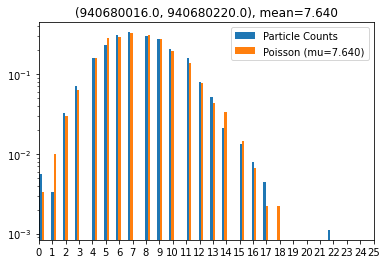

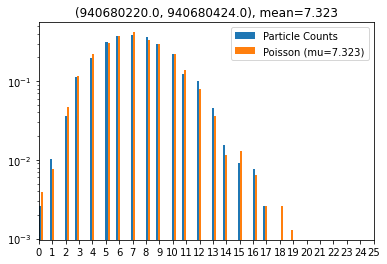

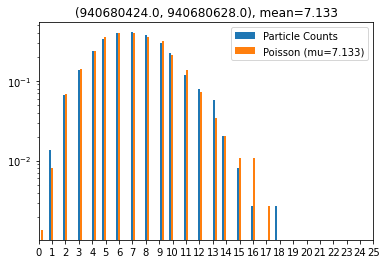

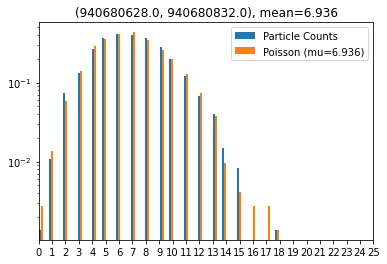

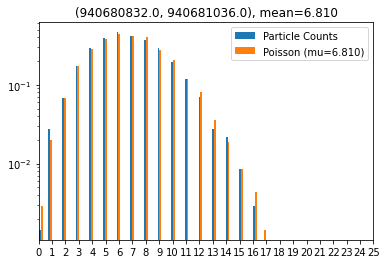

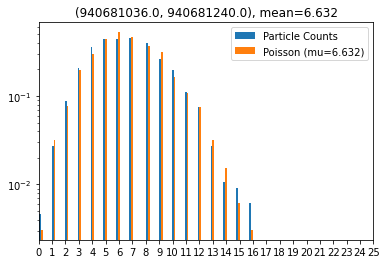

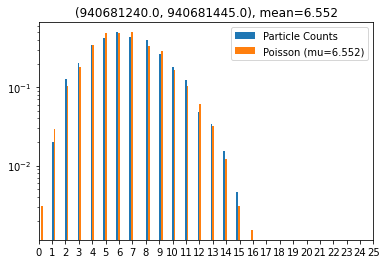

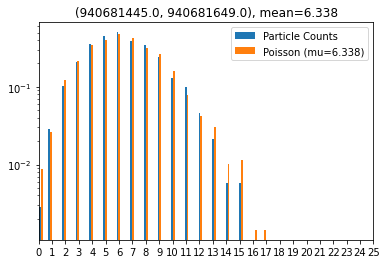

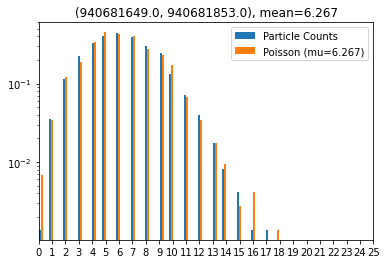

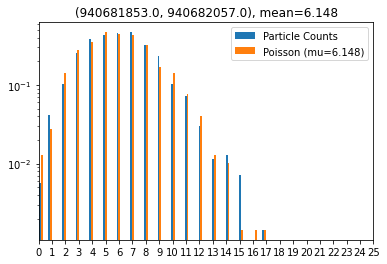

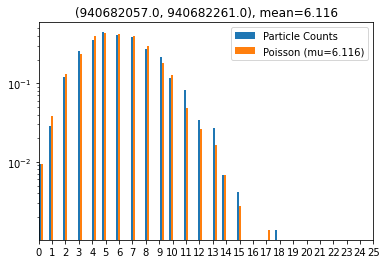

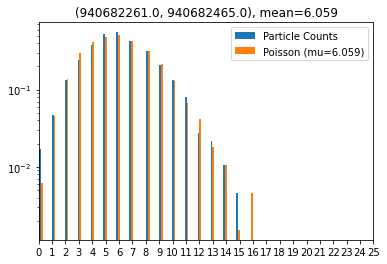

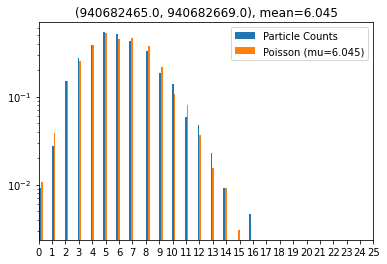

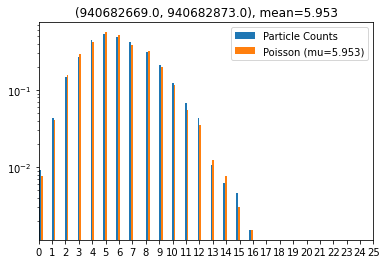

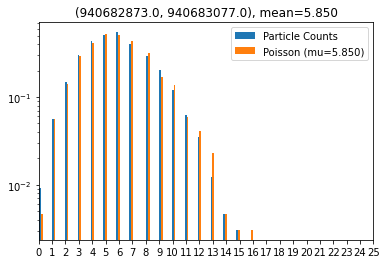

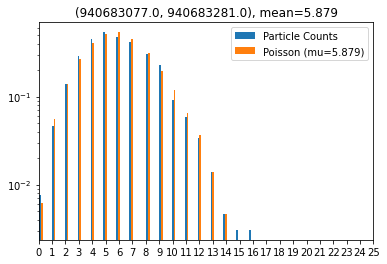

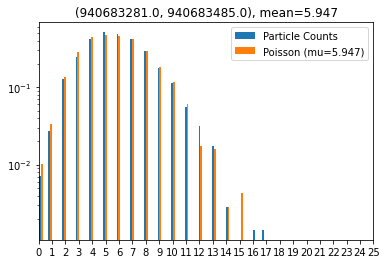

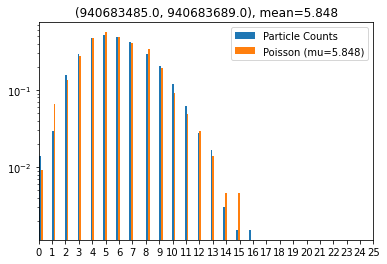

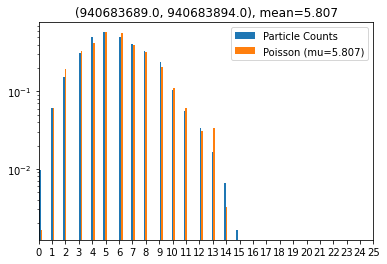

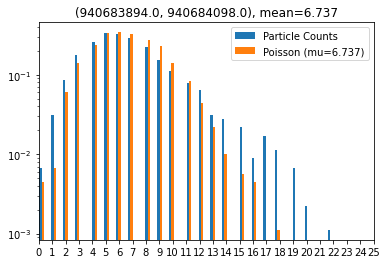

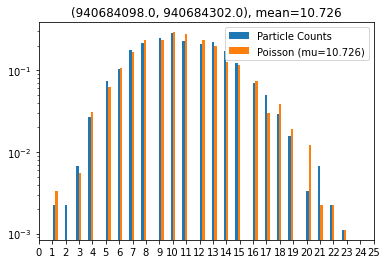

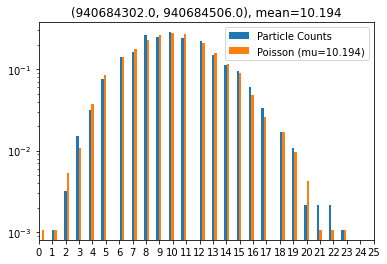

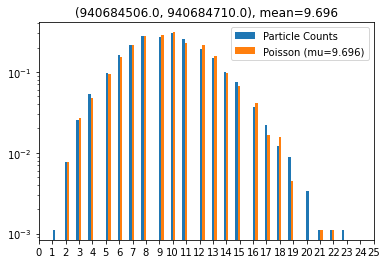

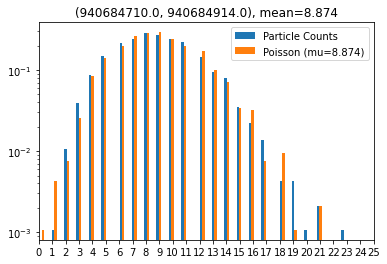

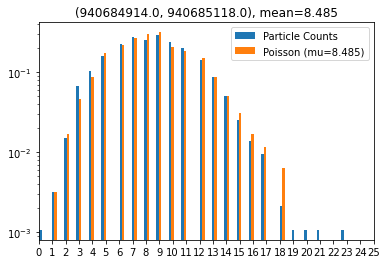

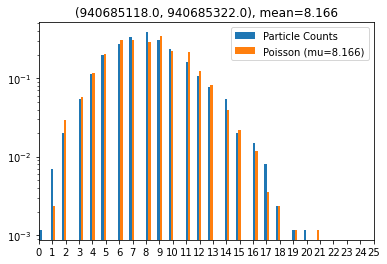

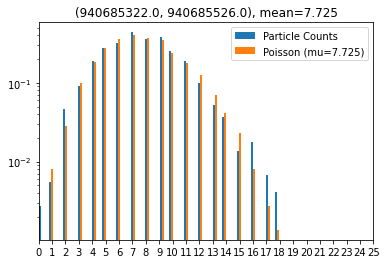

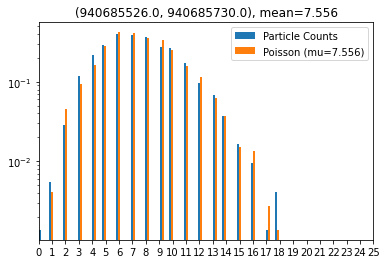

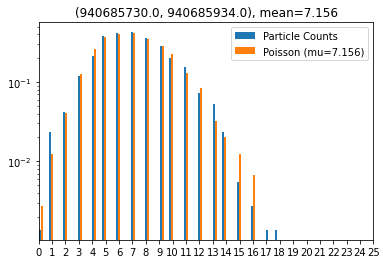

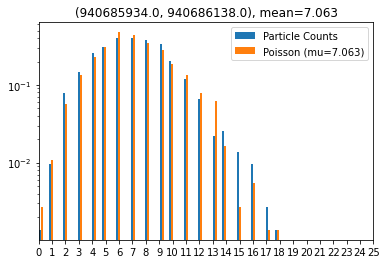

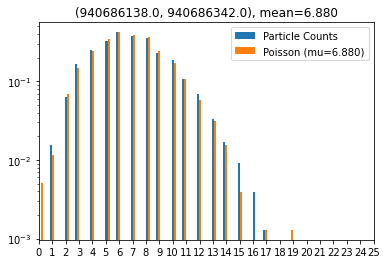

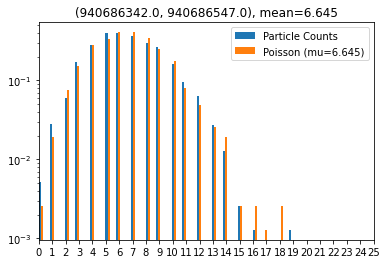

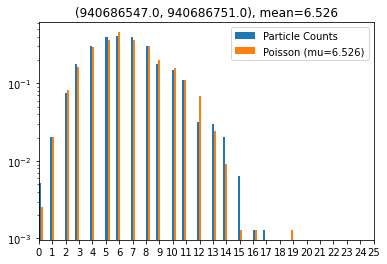

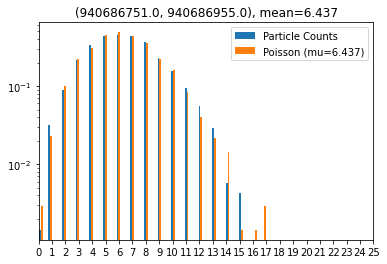

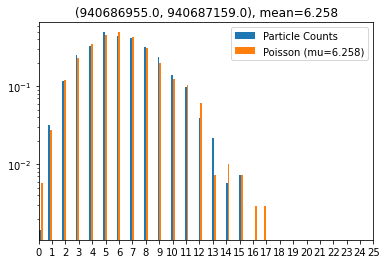

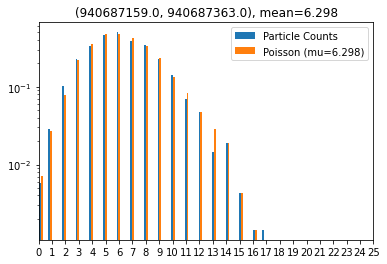

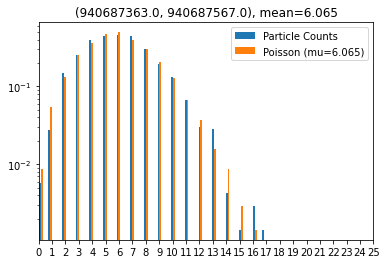

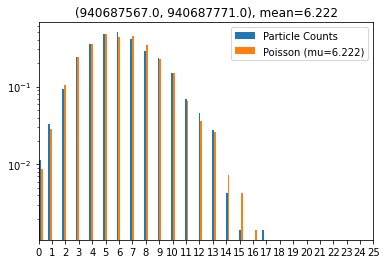

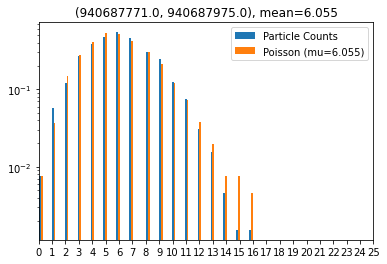

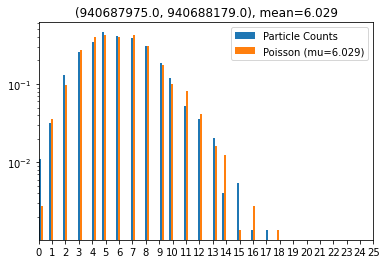

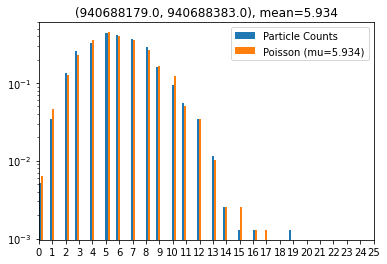

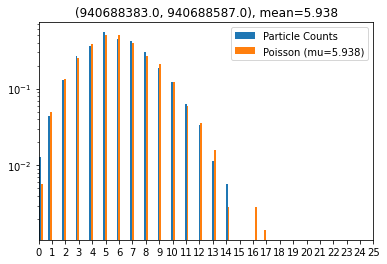

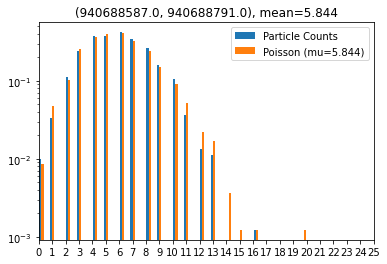

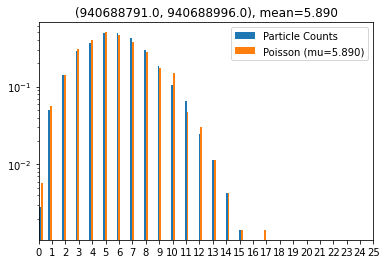

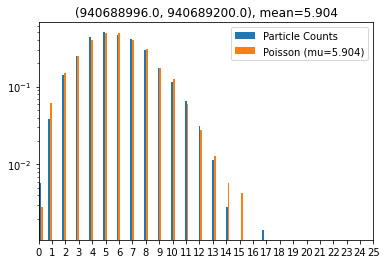

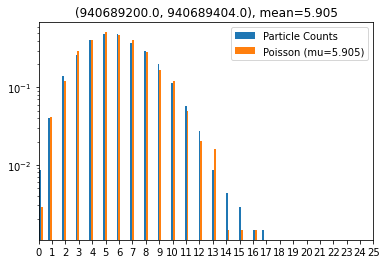

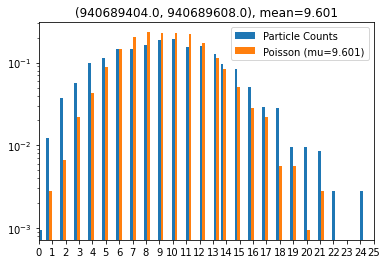

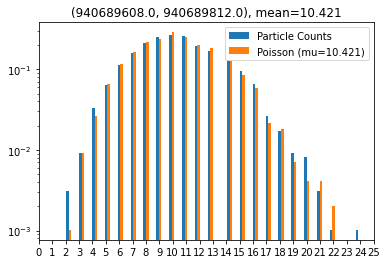

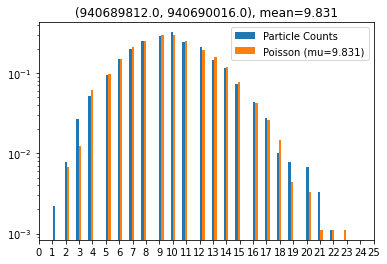

In [117]:
data_part = data[:,:100000]
minmax_t = np.linspace(data_part[0,0],data_part[0,-1],50)
minmax_t = np.round(minmax_t)
minmax_range_t = [(minmax_t[i],minmax_t[i+1]) for i in range(minmax_t.shape[0]-1)]
mean_list_t = []
for minmax in minmax_range_t:
    _,mean_t = comp_p_t(data_part,minmax)
    mean_list_t.append(mean_t)


By splitting into 50 segments, the distribution of particle counts is close enough to be seen as Poisson. Next step, I'm gonna see how the mean value varies with respect to time.

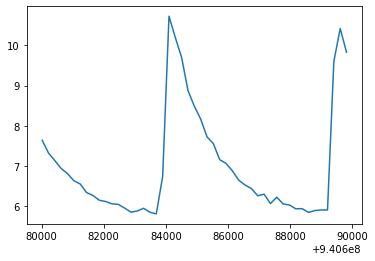

In [118]:
plt.plot(minmax_t[:-1],mean_list_t)
plt.show()

Now, let's take one period and explore the function.

The period is 5510 seconds.


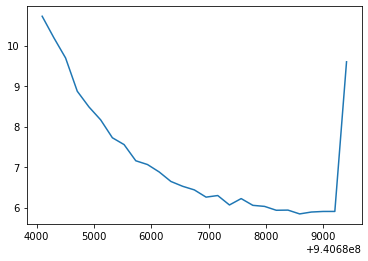

In [119]:
temp_arr = np.array(mean_list_t)
max_1 = temp_arr.max()
max_2 = temp_arr[temp_arr!=max_1].max()
ind_1 = int(np.where(temp_arr==max_1)[0])
ind_2 = int(np.where(temp_arr==max_2)[0])

xrange = minmax_t[:-1]
plt.plot(xrange[ind_1:ind_2],mean_list_t[ind_1:ind_2])
print("The period is %s seconds."%int(np.round(xrange[ind_2]-xrange[ind_1])))

           3             2
1.504e-16 x - 1.415e-07 x - 133.1 x + 1.252e+11


D:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


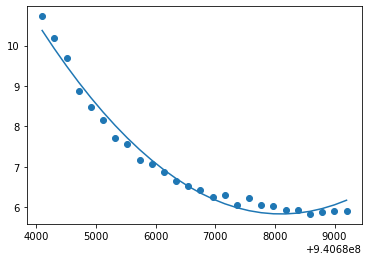

In [122]:
x = xrange[ind_1:ind_2][:-1]
y = mean_list_t[ind_1:ind_2][:-1]
parameter = np.polyfit(x, y, 3)
p = np.poly1d(parameter,variable='x')
print(p)
fig,ax=plt.subplots(1,1)
ax.scatter(x,y)
ax.plot(x,p(x))
plt.show()

I tried to find an exponential expression, but it doesn't fit. After trying so many parameters, I found that this data also does not fit polynomial strictly. Maybe we should try advanced Machine Learning regressioners. But, we can draw a conclusion that the background is Poisson distributions periodically varies with time in an unperceivable way. The period is 5510 seconds.

4) 100 millisecond = 0.1 s. Since we are given the data in seconds, we need to divide the mean and significance by 10. To keep the answer simple, I'll randomly pick 5 points in a period.

In [140]:
times = np.sort(np.random.choice(x,size=5, replace=False))
means=[]
for i in times:
    means.append(mean_list_t[int(np.where(minmax_t==i)[0])])
five_points = dict(zip(times,means))
prob = stats.norm.sf(5)
for t,m in five_points.items():
    sig = stats.poisson.isf(prob, m)
    print("At (%d+9.4068e8) seconds, for a 100 millisecond GRB, the mean is %.2f, the '5-sigma' threshold is %.2f."%(t-9.4068e8,m/10,sig/10))
    

At (4098+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 1.07, the '5-sigma' threshold is 3.10.
At (6547+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.65, the '5-sigma' threshold is 2.30.
At (7363+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.61, the '5-sigma' threshold is 2.20.
At (7567+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.62, the '5-sigma' threshold is 2.20.
At (8383+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.59, the '5-sigma' threshold is 2.20.


940686547.0